The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha0


# Designing Convolution Network Architectures
:label:`sec_cnn-design`

The 2010s has witnessed shift
from *feature engineering* to *network engineering*
in computer vision.
Since AlexNet (:numref:`sec_alexnet`)
beat conventional computer vision models on ImageNet,
constructing very deep networks
by stacking the same blocks,
especially $3 \times 3$ convolutions,
has been popularized by VGG networks (:numref:`sec_vgg`).
The network in network (:numref:`sec_nin`)
adds local nonlinearities via $1 \times 1$ convolutions
and uses global average pooling
to aggregate information
across all locations.
GoogLeNet (:numref:`sec_googlenet`)
is a multi-branch network that
combines the advantages from the
VGG network
and the network in network,
where its Inception block
adopts the strategy of
concatenated parallel transformations.
ResNets (:numref:`sec_resnet`)
stack residual blocks,
which are two-branch subnetworks
using identity mapping in one branch.
DenseNets (:numref:`sec_densenet`)
generalize the residual architectures.
Other notable architectures
include
MobileNets that use network learning to achieve high accuracy in
resource-constrained settings :cite:`Howard.Sandler.Chu.ea.2019`,
the Squeeze-and-Excitation Networks (SENets) that
allow for efficient information transfer between channels
:cite:`Hu.Shen.Sun.2018`,
and EfficientNets :cite:`tan2019efficientnet`
that scale up networks via neural architecture search.

Specifically, *neural architecture search* (NAS) :cite:`zoph2016neural,liu2018darts`
is the process of automating neural network architectures.
Given a fixed search space,
NAS uses a search strategy
to automatically select
an architecture within the search space
based on the returned performance estimation.
The outcome of NAS
is a single network instance.

Instead of focusing on designing such individual instances,
an alternative approach
is to *design network design spaces*
that characterize populations of networks :cite:`Radosavovic.Kosaraju.Girshick.ea.2020`.
This method
combines the strength of manual design and NAS.
Through semi-automatic procedures (like in NAS),
designing network design spaces
explores the structure aspect of network design
from the initial *AnyNet* design space.
It then proceeds to discover design principles (like in manual design)
that lead to simple and regular networks: *RegNets*.
Before shedding light on these design principles,
let's start with
the initial design space.

## The AnyNet Design Space

The initial design space is called *AnyNet*,
a relatively unconstrained design space,
where we can focus on
exploring network structure
assuming standard, fixed blocks such as ResNeXt (:numref:`subsec_resnext`).
Specifically,
the network structure
includes
elements
such as the number of blocks
and the number of output channels
in each stage,
and the number of groups (group width) and bottleneck ratio
within
each ResNeXt block.



![The AnyNet design space. Besides the number of groups and bottleneck ratio within each block, design choices include depth $d_i$ and the number of output channels $w_i$ for any stage $i$.](http://d2l.ai/_images/anynet.svg)
:label:`fig_anynet`

The AnyNet design space
is shown in :numref:`fig_anynet`.
This network
begins with a *stem*,
followed by a *body* with $n$ stages of transformation,
and a final *head*.
More concretely,
the network stem
is a $3 \times 3$ convolution with stride 2
that halves the height and width of an input image.
The network head
is a global average pooling followed
by a fully connected layer to predict
the output class.
Note that
the network stem and head
are kept fixed and simple,
so that the design focus in
on the network body that is central
to performance.
Specifically,
the network body
consists of $n$ stages of transformation
($n$ is given),
where stage $i$
consists of $d_i$ ResNeXt blocks
with $w_i$ output channels,
and progressively
halves height and width via the first block
(setting `use_1x1conv=True, strides=2` in `d2l.ResNeXtBlock` in :numref:`subsec_resnext`).
Let's further
denote
the bottleneck ratio and
the number of groups (group width) 
within
each ResNeXt block for stage $i$
as $b_i$ and $g_i$, respectively.
Overall,
despite of the straightforward network structure,
varying $b_i$, $g_i$, $w_i$, and $d_i$
results in
a vast number of
possible networks in the AnyNet design space.


To implement AnyNet,
we first define its network stem.


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class AnyNet(d2l.Classifier):
    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())

Each stage consists of `depth` ResNeXt blocks,
where `num_channels` specifies the block width.
Note that the first block halves the height and width of input images.


In [2]:
@d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):
    blk = []
    for i in range(depth):
        if i == 0:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul,
                use_1x1conv=True, strides=2))
        else:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)

Putting the network stem, body, and head together,
we complete the implementation of AnyNet.


In [3]:
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.stem(stem_channels))
    for i, s in enumerate(arch):
        self.net.add_module(f'stage{i+1}', self.stage(*s))
    self.net.add_module('head', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

## Constraining Design Spaces with Lower Error Distributions

For any stage $i$ of AnyNet,
the design choices are 
the bottleneck ratio $b_i$ 
and the number of groups $g_i$
within each block,
block width $w_i$,
and depth $d_i$.
The designing network design spaces
process starts
from relatively unconstrained
network structure characterized
by ($b_i$, $g_i$, $w_i$, $d_i$)
in the initial AnyNet design space.
Then this process
progressively samples models
from the input design space
to evaluate the error distribution :cite:`radosavovic2019network`
as a quality indicator
to output a more constrained
design space with simpler models that may have
better quality. 

Let's detail
this quality indicator for design spaces.
Given $n$ models sampled from some design space,
the *error empirical distribution function* $F(e)$
measures the fraction of models
with errors $e_i$ lower than $e$:

$$F(e) = \frac{1}{n}\sum_{i=1}^n \mathbf{1}(e_i < e).$$


Starting from the initial unconstrained AnyNet design space ($\text{AnyNetX}_A$ in :cite:`Radosavovic.Kosaraju.Girshick.ea.2020`),
sharing the bottle network ratio $b_i = b$ for all stages $i$ results in a more constrained design space $\text{AnyNetX}_B$.
Sampling and training $n=500$ models from $\text{AnyNetX}_A$ and $\text{AnyNetX}_B$ each,
left of :numref:`fig_regnet-paper-fig5`
shows that both design spaces have similar quality.
Since simpler is better,
we continue to search from $\text{AnyNetX}_B$
by additionally sharing the number of groups $g_i = g$.
This leads to a further simplified design space
$\text{AnyNetX}_C$ with virtually no change
in error distributions (right of :numref:`fig_regnet-paper-fig5`).

![Comparing error empirical distribution functions of design spaces. The legends show the min error and mean error. Sharing bottleneck ratio (from $\text{AnyNetX}_A$ to  $\text{AnyNetX}_B$) and sharing the number of groups (from $\text{AnyNetX}_B$ to $\text{AnyNetX}_C$) simplify the design space with virtually no change in error distributions (figure taken from :cite:`Radosavovic.Kosaraju.Girshick.ea.2020`).](../img/regnet-paper-fig5.png)
:width:`600px`
:label:`fig_regnet-paper-fig5`

Investigating good and bad models from $\text{AnyNetX}_C$ suggests that it may be useful to increase width across stages :cite:`Radosavovic.Kosaraju.Girshick.ea.2020`.
Empirically, simplifying
$\text{AnyNetX}_C$ to $\text{AnyNetX}_D$
with $w_{i} \leq w_{i+1}$
improves the quality of design spaces (left of  :numref:`fig_regnet-paper-fig7`).
Similarly,
adding further constraints of $d_{i} \leq d_{i+1}$
to increase network depth across stages
gives an even better $\text{AnyNetX}_E$
(right of :numref:`fig_regnet-paper-fig7`).

![Comparing error empirical distribution functions of design spaces. The legends show the min error and mean error. Increasing network width across stages (from $\text{AnyNetX}_C$ to  $\text{AnyNetX}_D$) and increasing network depth across stages (from $\text{AnyNetX}_D$ to $\text{AnyNetX}_E$) simplify the design space with improved  error distributions (figure taken from :cite:`Radosavovic.Kosaraju.Girshick.ea.2020`).](../img/regnet-paper-fig7.png)
:width:`600px`
:label:`fig_regnet-paper-fig7`



## RegNet

The resulting $\text{AnyNetX}_E$ design space
consists of simple networks
following easy-to-interpret design principles:

* Share the bottle network ratio $b_i = b$ for all stages $i$;
* Share the number of groups $g_i = g$ for all stages $i$;
* Increase network width across stages: $w_{i} \leq w_{i+1}$;
* Increase network depth across stages: $d_{i} \leq d_{i+1}$.

Following these design principles, :cite:`Radosavovic.Kosaraju.Girshick.ea.2020` proposed quantized linear constraints to
$w_i$ and $d_i$ increasing,
leading to
RegNetX using ResNeXt blocks
and RegNetY that additionally uses operators from SENets :cite:`Hu.Shen.Sun.2018`.
As an example,
we implement a 32-layer RegNetX variant
characterized by

* $b_i = 1;$
* $g_i = 16;$
* $w_1 = 32, w_2=80;$
* $d_1 = 4, d_2=6.$


In [4]:
class RegNet32(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

We can see that each RegNet stage progressively reduces resolution and increases output channels.


In [5]:
RegNet32().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


/home/d2l-worker/miniconda3/envs/d2l-en-release-1/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Training

Training the 32-layer RegNet on the Fashion-MNIST dataset is just like before.


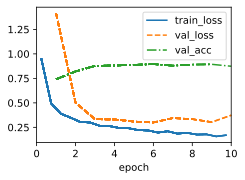

In [6]:
model = RegNet32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

## Discussion

With desirable properties like locality and translation invariance (:numref:`sec_why-conv`)
for vision,
CNNs have been the dominant architectures in this area.
Recently,
transformers (:numref:`sec_transformer`) :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021,touvron2021training`
and MLPs :cite:`tolstikhin2021mlp`
have also sparked research beyond
the well-established CNN architectures for vision.
Specifically,
although lacking of the aforementioned
inductive biases inherent to CNNs,
vision transformers (:numref:`sec_vision-transformer`)
attained state-of-the-art performance
in large-scale image classification in early 2020s,
showing that
*scalability trumps inductive biases*
:cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`.
In other words,
it is often possible to
train large transformers
to outperform large CNNs on large datasets.
Inspired
by the superior scaling behavior of
transformers (:numref:`sec_large-pretraining-transformers`) with multi-head self-attention (:numref:`sec_multihead-attention`),
the process of gradually
improving from a standard ResNet architecture
toward the design of a vision transformer
leads to a family of CNNs called the ConvNeXt models
that compete favorably with transformers for vision :cite:`liu2022convnet`.
We refer the interested readers
to CNN design discussions
in the ConvNeXt paper :cite:`liu2022convnet`.



## Exercises

1. Increase the number of stages to 4. Can you design a deeper RegNet that performs better?
1. De-ResNeXt-ify RegNets by replacing the ResNeXt block with the ResNet block. How does your new model perform?
1. Implement multiple instances of a "VioNet" family by *violating* the design principles of RegNet. How do they perform? Which of ($d_i$, $w_i$, $g_i$, $b_i$) is the most important factor?


[Discussions](https://discuss.d2l.ai/t/7463)
